# SpeakUp2.0: Eye Contact Estimation

### 0. Import Necessary Packages

In [1]:
import os
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb

print("Packages imported successfully")

Packages imported successfully


### 1. Define key Directories, Variables & Functions

In [10]:
### DIRECTORIES ###
input_data = r'Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\4_EYE_TRACKING\input_data'
output_data = r'Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\4_EYE_TRACKING\output_data'
output_figures = r'Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\4_EYE_TRACKING\output_figures'
outout_figures_2 = r'Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\4_EYE_TRACKING\output_figures_2'

print('input data will be read from: ', input_data)
print('output data will be saved to: ', output_data)
print('output figures will be saved to: ', output_figures)


### VARIABLES ###
event_pairs = [
    ("Speech_Start", "SUD_1_Start"),
    ("SUD_1_End", "SUD_2_Start"),
    ("SUD_2_End", "SUD_3_Start")
]

participant_IDs = ['pilot_01_d2', 'pilot_01_d3',
                   'pilot_02_d2', 'pilot_02_d3',
                   'pilot_04_d2', 
                   'pilot_05_d2',
                   'pilot_06_d2'] 


eye_contact_threshold = 0.5  # # Define the duration threshold for eye contact in seconds

### FUNCTIONS ###


def quantify_eye_contact(segment):
    # Calculate the time difference between consecutive rows in seconds
    segment['time_diff'] = segment['timestamp [ns]'].diff() / 1e9  # Convert from ns to seconds
    
    # Initialize variables to track eye contact periods
    eye_contact_periods = []
    current_period_start = None
    current_duration = 0

    # Loop through the segment to detect eye contact periods
    for idx, row in segment.iterrows():
        if row['gaze on face']:  # If gaze is on face (True)
            if current_period_start is None:
                current_period_start = row['timestamp [ns]']  # Start a new period
            current_duration += row['time_diff']  # Accumulate duration
        else:
            if current_duration >= eye_contact_threshold:
                # Save the start and end of the eye contact period
                eye_contact_periods.append((current_period_start, row['timestamp [ns]']))
            # Reset
            current_period_start = None
            current_duration = 0
    
    # Handle the case where the last period continues till the end
    if current_duration >= eye_contact_threshold:
        eye_contact_periods.append((current_period_start, segment['timestamp [ns]'].iloc[-1]))
    
    return eye_contact_periods


# Function to extract data for specific event pairs
def extract_data_for_event_pair(start_event, end_event, gaze_data, gaze_on_face_data, buttonbox_data):
    # Get LSL times for the start and end events
    start_time = buttonbox_data.loc[buttonbox_data['ButtonBox_Channel 1'] == start_event, 'LSL_Time'].values[0]
    end_time = buttonbox_data.loc[buttonbox_data['ButtonBox_Channel 1'] == end_event, 'LSL_Time'].values[0]
    
    # Find corresponding eye tracking timestamps in gaze data
    gaze_data_segment = gaze_data[(gaze_data['timestamp [ns]'] >= start_time) & (gaze_data['timestamp [ns]'] <= end_time)]
    
    # Find corresponding gaze on face data based on timestamps
    gaze_on_face_segment = gaze_on_face_data[gaze_on_face_data['timestamp [ns]'].isin(gaze_data_segment['timestamp [ns]'])]
    
    return gaze_on_face_segment




input data will be read from:  Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\4_EYE_TRACKING\input_data
output data will be saved to:  Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\4_EYE_TRACKING\output_data
output figures will be saved to:  Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\4_EYE_TRACKING\output_figures


### 2. Align and Segment the Gaze_on_Face Data 

In [18]:
participant_IDs = [
                   'pilot_02_d2', 
                   
                   
                   ] 
for participant_ID in participant_IDs:  # Loop through all participants
    print('Processing participant: ', participant_ID)
    
    # Initialize file variables to search them later based on the participant's ID
    gaze_file = None
    gaze_on_face_file = None
    buttonbox_file = None
        
    # Look for the participant's data in the input directory
    for root, dirs, files in os.walk(input_data):  # Loop through all files in the input directory
        
        for file in files:                           # Loop through all files in the input directory
            
            if participant_ID in file:                # Check if the participant's ID is in the file name
                
                if 'cloud_lsl_aligned_gaze' in file:                    # Check if the file is gaze data
                    gaze_file = os.path.join(root, file)
                    
                elif 'gaze_on_face' in file:             # Check if the file is gaze on face data
                    gaze_on_face_file = os.path.join(root, file)
                    
                elif 'ButtonBox'  in file:                # Check if the file is buttonbox data
                    buttonbox_file = os.path.join(root, file)
                    
    # Check if all files were found
    if gaze_file and gaze_on_face_file and buttonbox_file:
        print(f'Found all files for {participant_ID}')
        
        # Load the files
        gaze_data = pd.read_csv(gaze_file)
        gaze_on_face_data = pd.read_csv(gaze_on_face_file)
        buttonbox_data = pd.read_csv(buttonbox_file)
        
        
        # Process each event pair
        for start_event, end_event in event_pairs:
            
            print(f'Extracting data for {start_event} - {end_event}')
            # Get LSL times for the start and end events
            start_time = buttonbox_data.loc[buttonbox_data['ButtonBox_Channel 1'] == start_event, 'LSL_Time'].values[0]
            end_time = buttonbox_data.loc[buttonbox_data['ButtonBox_Channel 1'] == end_event, 'LSL_Time'].values[0]
            print(f'{start_event} time: {start_time}')
            print(f'{end_event} time: {end_time}')
            
            # Find corresponding LSL eye tracking timestamps in gaze data
            gaze_data_segment = gaze_data[(gaze_data['lsl_time [s]'] >= start_time) & (gaze_data['lsl_time [s]'] <= end_time)]
            # print('Gaze data segment', gaze_data_segment.head())
            
            # Extract the start and end timestamps in nanoseconds from the gaze data segment
            start_ns = gaze_data_segment['timestamp [ns]'].min()
            end_ns = gaze_data_segment['timestamp [ns]'].max()
            print(f'Start timestamp [ns]: {start_ns}')
            print(f'End timestamp [ns]: {end_ns}')
                        
            # Find the corresponding gaze on face data based on the start and end timestamps
            gaze_on_face_segment = gaze_on_face_data[(gaze_on_face_data['timestamp [ns]'] >= start_ns) & 
                                                    (gaze_on_face_data['timestamp [ns]'] <= end_ns)]
            
            # print('gaze on face segment', gaze_on_face_segment.head())
            
            # Save the extracted data for this event pair
            print(f'Saving data for  {start_event} - {end_event}')
            output_filename = f'{participant_ID}_{start_event}_{end_event}_gaze_on_face.csv'
            output_filepath = os.path.join(output_data, output_filename)
            gaze_on_face_segment.to_csv(output_filepath, index=False)
            print(f'Saved {output_filename}')
            print('\n')
           
    else:
        print(f'Missing files for {participant_ID}. Skipping participant.')
        print('\n')

            
            
            
            


Processing participant:  pilot_02_d2
Found all files for pilot_02_d2
Extracting data for Speech_Start - SUD_1_Start
Speech_Start time: 10447.834667226534
SUD_1_Start time: 10567.797653984786
Start timestamp [ns]: 1718185728231521896
End timestamp [ns]: 1718185848193049896
Saving data for  Speech_Start - SUD_1_Start
Saved pilot_02_d2_Speech_Start_SUD_1_Start_gaze_on_face.csv


Extracting data for SUD_1_End - SUD_2_Start
SUD_1_End time: 10573.137020601042
SUD_2_Start time: 10687.984436286884
Start timestamp [ns]: 1718185853538047896
End timestamp [ns]: 1718185968379931896
Saving data for  SUD_1_End - SUD_2_Start
Saved pilot_02_d2_SUD_1_End_SUD_2_Start_gaze_on_face.csv


Extracting data for SUD_2_End - SUD_3_Start
SUD_2_End time: 10693.643868549649
SUD_3_Start time: 10808.265308402906
Start timestamp [ns]: 1718185974045181896
End timestamp [ns]: 1718186088661956896
Saving data for  SUD_2_End - SUD_3_Start
Saved pilot_02_d2_SUD_2_End_SUD_3_Start_gaze_on_face.csv




### 3. Now we Process the Segmented Data 

Processing participant: pilot_02_d2
Processing segment: Speech_Start to SUD_1_Start
Eye contact periods for Speech_Start to SUD_1_Start:
Start: 1718185729417521896, End: 1718185729948026896, Duration: 0.53 seconds
Start: 1718185738496027896, End: 1718185739221652896, Duration: 0.73 seconds
Start: 1718185739226652896, End: 1718185740202653896, Duration: 0.98 seconds
Start: 1718185742629797896, End: 1718185743225297896, Duration: 0.60 seconds
Start: 1718185759330297896, End: 1718185760126047896, Duration: 0.80 seconds
Start: 1718185762107922896, End: 1718185762653422896, Duration: 0.55 seconds
Start: 1718185767753172896, End: 1718185768263672896, Duration: 0.51 seconds
Start: 1718185782617046896, End: 1718185783222549896, Duration: 0.61 seconds
Start: 1718185786390547896, End: 1718185787591671896, Duration: 1.20 seconds
Start: 1718185790139046896, End: 1718185791485296896, Duration: 1.35 seconds
Start: 1718185791575296896, End: 1718185792195930896, Duration: 0.62 seconds
Start: 171818579

<Figure size 600x100 with 0 Axes>

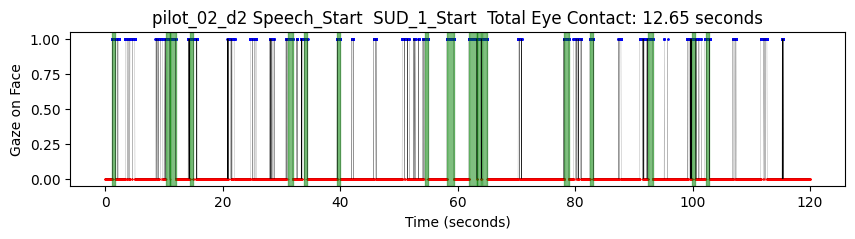

Processing segment: SUD_1_End to SUD_2_Start
Eye contact periods for SUD_1_End to SUD_2_Start:
Start: 1718185863432172896, End: 1718185864703422896, Duration: 1.27 seconds
Start: 1718185871164422896, End: 1718185872555672896, Duration: 1.39 seconds
Start: 1718185876529423896, End: 1718185877525298896, Duration: 1.00 seconds
Start: 1718185878936673896, End: 1718185879552298896, Duration: 0.62 seconds
Start: 1718185882489923896, End: 1718185883230688896, Duration: 0.74 seconds
Start: 1718185883636060896, End: 1718185884301673896, Duration: 0.67 seconds
Start: 1718185889676673896, End: 1718185890187173896, Duration: 0.51 seconds
Start: 1718185890302299896, End: 1718185891158048896, Duration: 0.86 seconds
Start: 1718185900651924896, End: 1718185901492674896, Duration: 0.84 seconds
Start: 1718185905005924896, End: 1718185905726549896, Duration: 0.72 seconds
Start: 1718185910941425896, End: 1718185911602050896, Duration: 0.66 seconds
Start: 1718185911682175896, End: 1718185912232679896, Dura

<Figure size 600x100 with 0 Axes>

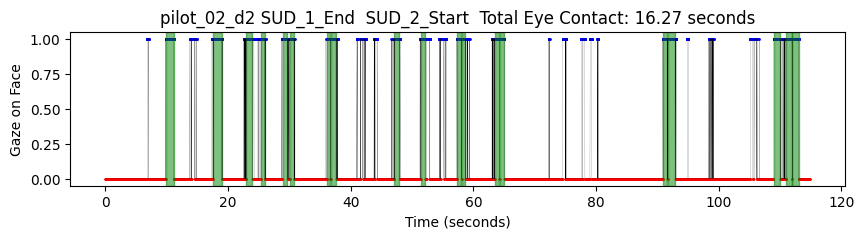

Processing segment: SUD_2_End to SUD_3_Start
Eye contact periods for SUD_2_End to SUD_3_Start:
Start: 1718185991236184896, End: 1718185992192059896, Duration: 0.96 seconds
Start: 1718186016054313896, End: 1718186016930063896, Duration: 0.88 seconds
Start: 1718186041653201896, End: 1718186042704069896, Duration: 1.05 seconds
Start: 1718186060380573896, End: 1718186060886073896, Duration: 0.51 seconds
Start: 1718186080604453896, End: 1718186081149953896, Duration: 0.55 seconds
Start: 1718186085358829896, End: 1718186085874330896, Duration: 0.52 seconds


<Figure size 600x100 with 0 Axes>

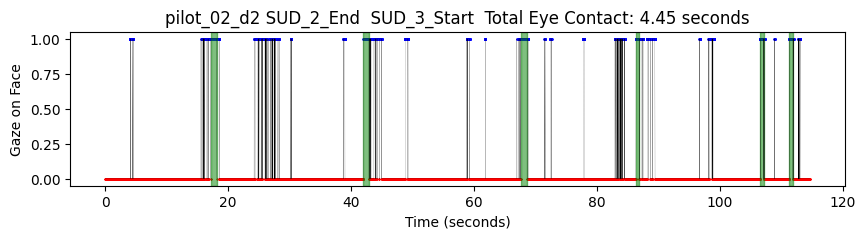

Eye contact summary saved to: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\4_EYE_TRACKING\output_data\eye_contact_summary.csv


In [20]:
eye_contact_results = []

for participant_ID in participant_IDs:  # Loop through all participants
    print(f'Processing participant: {participant_ID}')
    
    # Loop over segments and quantify eye contact
    for start_event, end_event in event_pairs:
        print(f'Processing segment: {start_event} to {end_event}')
        
        # Load the data 
        data = pd.read_csv(os.path.join(output_data, f'{participant_ID}_{start_event}_{end_event}_gaze_on_face.csv'))
        
        # Quantify eye contact
        eye_contact_periods = quantify_eye_contact(data)
        
        # Calculate total eye contact time
        total_eye_contact = sum((end_ns - start_ns) / 1e9 for start_ns, end_ns in eye_contact_periods)  # in seconds
        
        # Print the detected eye contact periods
        print(f'Eye contact periods for {start_event} to {end_event}:')
        for start_ns, end_ns in eye_contact_periods:
            duration = (end_ns - start_ns) / 1e9  # Convert to seconds
            print(f'Start: {start_ns}, End: {end_ns}, Duration: {duration:.2f} seconds')

        # Plot the dynamics of eye contact
        plt.figure(figsize=(6, 1))
        
        # Get the starting timestamp to reset the time to 0
        start_time = data['timestamp [ns]'].min() / 1e9  # Convert to seconds
        
        # Adjust the timestamps to start at 0
        time_in_seconds = (data['timestamp [ns]'] / 1e9) - start_time
        
         # Separate the gaze on face data into two subsets: one for 0 and one for 1
        mask_on_face = data['gaze on face'] == 1
        mask_not_on_face = data['gaze on face'] == 0
        
        # Plot the markers for 0 and 1 with different colors
        plt.figure(figsize=(10, 2))
        plt.plot(time_in_seconds, data['gaze on face'], color='black', linewidth=0.1, label='Gaze Transition')
        plt.scatter(time_in_seconds[mask_not_on_face], data['gaze on face'][mask_not_on_face], color='red', label='Gaze Not on Face', s=0.1)
        plt.scatter(time_in_seconds[mask_on_face], data['gaze on face'][mask_on_face], color='blue', label='Gaze on Face', s=1)
        
        # Highlight the eye contact periods on the plot
        for start_ns, end_ns in eye_contact_periods:
            plt.axvspan((start_ns / 1e9) - start_time, (end_ns / 1e9) - start_time, 
                        color='green', alpha=0.5, label='Eye Contact')

        # Update the title with the total amount of eye contact
        plt.title(f'{participant_ID} {start_event}  {end_event}  Total Eye Contact: {total_eye_contact:.2f} seconds')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Gaze on Face')
        # plt.legend()
        
        # Save the plot
        output_filename = f'{participant_ID}_{start_event}_{end_event}_eye_contact.png'
        output_filepath = os.path.join(outout_figures_2, output_filename)
        plt.savefig(output_filepath, dpi=300)
        
        
        plt.show()
        plt.close()
        
        # Append results to the list
        eye_contact_results.append({
        'participant_ID': participant_ID,
        'condition': start_event,
        'total_eye_contact': total_eye_contact
        })

        
    
    
        
        # ### OPTIONAL:  Plot the first 10 seconds of the data ###
        # print(f'Plotting the first 10 seconds for {start_event} to {end_event}')
        
        # # Filter the data for the first 10 seconds
        # ten_seconds_later = start_time + 10
        # first_10_sec_segment = data[data['timestamp [ns]'] / 1e9 <= ten_seconds_later]
        
        # # Adjust the timestamps to start at 0 for the first 10 seconds
        # first_10_sec_time_in_seconds = (first_10_sec_segment['timestamp [ns]'] / 1e9) - start_time
        
        # # Plot the first 10 seconds
        # plt.figure(figsize=(18, 2))
        # plt.plot(first_10_sec_time_in_seconds, first_10_sec_segment['gaze on face'], color='black', linewidth=0.1, label='Gaze Transition')
        # plt.scatter(first_10_sec_time_in_seconds[first_10_sec_segment['gaze on face'] == 0], 
        #             first_10_sec_segment['gaze on face'][first_10_sec_segment['gaze on face'] == 0], 
        #             color='red', s=0.1, label='Gaze Not on Face')
        # plt.scatter(first_10_sec_time_in_seconds[first_10_sec_segment['gaze on face'] == 1], 
        #             first_10_sec_segment['gaze on face'][first_10_sec_segment['gaze on face'] == 1], 
        #             color='blue', s=1, label='Gaze on Face')
        # # Highlight the eye contact periods that fall within the first 10 seconds
        # for start_ns, end_ns in eye_contact_periods:
        #     # Adjust start and end to only plot within the first 10 seconds
        #     adjusted_start = max(start_ns / 1e9, start_time)
        #     adjusted_end = min(end_ns / 1e9, ten_seconds_later)
            
        #     # Only plot if the adjusted period is within the first 10 seconds
        #     if adjusted_end > adjusted_start:
        #         plt.axvspan(adjusted_start - start_time, adjusted_end - start_time, 
        #                     color='green', alpha=0.5, label='Eye Contact')

        
        
        # plt.title(f'First 10 Seconds of Gaze Data: {start_event} to {end_event}')
        # plt.xlabel('Time (seconds)')
        # plt.ylabel('Gaze on Face')
        # plt.legend()
        
        # # Save the plot for the first 10 seconds
        # output_filename_first_10 = f'{participant_ID}_{start_event}_{end_event}_first_10_sec_eye_contact.png'
        # output_filepath_first_10 = os.path.join(output_figures, output_filename_first_10)
        # plt.savefig(output_filepath_first_10)
        
        # plt.show()
        # plt.close()
        
# Convert the results list to a DataFrame
eye_contact_df = pd.DataFrame(eye_contact_results)
# Save the DataFrame to a CSV file
output_csv_filepath = os.path.join(output_data, 'eye_contact_summary.csv')
#eye_contact_df.to_csv(output_csv_filepath, index=False)

print(f'Eye contact summary saved to: {output_csv_filepath}')


#### 4. Plotting Each Participant For RESULTS 

Processing participant: pilot_02_d2
Processing segment: Speech_Start to SUD_1_Start
Eye contact periods for Speech_Start to SUD_1_Start:
Start: 1718185729417521896, End: 1718185729948026896, Duration: 0.53 seconds
Start: 1718185738496027896, End: 1718185739221652896, Duration: 0.73 seconds
Start: 1718185739226652896, End: 1718185740202653896, Duration: 0.98 seconds
Start: 1718185742629797896, End: 1718185743225297896, Duration: 0.60 seconds
Start: 1718185759330297896, End: 1718185760126047896, Duration: 0.80 seconds
Start: 1718185762107922896, End: 1718185762653422896, Duration: 0.55 seconds
Start: 1718185767753172896, End: 1718185768263672896, Duration: 0.51 seconds
Start: 1718185782617046896, End: 1718185783222549896, Duration: 0.61 seconds
Start: 1718185786390547896, End: 1718185787591671896, Duration: 1.20 seconds
Start: 1718185790139046896, End: 1718185791485296896, Duration: 1.35 seconds
Start: 1718185791575296896, End: 1718185792195930896, Duration: 0.62 seconds
Start: 171818579

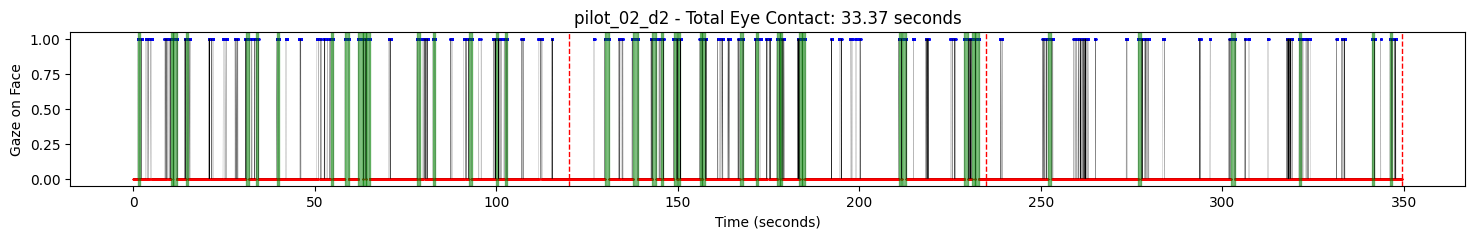

Eye contact summary saved to: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\4_EYE_TRACKING\output_data\eye_contact_summary.csv


In [21]:
eye_contact_results = []

for participant_ID in participant_IDs:  # Loop through all participants
    print(f'Processing participant: {participant_ID}')

    # Initialize variables for storing cumulative time and gaze data
    cumulative_time = 0  # This will accumulate the time across segments
    total_eye_contact_for_plot = 0  # To keep track of total eye contact for the combined plot
    
    plt.figure(figsize=(18, 2))  # Create a single plot for all segments
    
    # Loop over segments and quantify eye contact
    for start_event, end_event in event_pairs:
        print(f'Processing segment: {start_event} to {end_event}')
        
        # Load the data
        data = pd.read_csv(os.path.join(output_data, f'{participant_ID}_{start_event}_{end_event}_gaze_on_face.csv'))
        
        # Quantify eye contact
        eye_contact_periods = quantify_eye_contact(data)
        
        # Calculate total eye contact time
        total_eye_contact = sum((end_ns - start_ns) / 1e9 for start_ns, end_ns in eye_contact_periods)  # in seconds
        total_eye_contact_for_plot += total_eye_contact  # Add this to the total eye contact for the plot
        
        # Print the detected eye contact periods
        print(f'Eye contact periods for {start_event} to {end_event}:')
        for start_ns, end_ns in eye_contact_periods:
            duration = (end_ns - start_ns) / 1e9  # Convert to seconds
            print(f'Start: {start_ns}, End: {end_ns}, Duration: {duration:.2f} seconds')
        
        # Get the starting timestamp to reset the time to 0
        start_time = data['timestamp [ns]'].min() / 1e9  # Convert to seconds
        
        # Adjust the timestamps to start at 0
        time_in_seconds = (data['timestamp [ns]'] / 1e9) - start_time + cumulative_time
        
        # Calculate mask for gaze on face and not on face
        mask_on_face = data['gaze on face'] == 1
        mask_not_on_face = data['gaze on face'] == 0
        
        # Plot the time series for this segment
        plt.plot(time_in_seconds, data['gaze on face'], color='black', linewidth=0.1, label='Gaze Transition' if cumulative_time == 0 else "")
        plt.scatter(time_in_seconds[mask_not_on_face], data['gaze on face'][mask_not_on_face], color='red', label='Gaze Not on Face' if cumulative_time == 0 else "", s=0.1)
        plt.scatter(time_in_seconds[mask_on_face], data['gaze on face'][mask_on_face], color='blue', label='Gaze on Face' if cumulative_time == 0 else "", s=1)
        
        # Highlight the eye contact periods on the plot
        for start_ns, end_ns in eye_contact_periods:
            plt.axvspan((start_ns / 1e9) - start_time + cumulative_time, (end_ns / 1e9) - start_time + cumulative_time, 
                        color='green', alpha=0.5, label='Eye Contact' if cumulative_time == 0 else "")
        
        # Update cumulative time for the next segment
        cumulative_time += time_in_seconds.iloc[-1] - time_in_seconds.iloc[0]
        
        # Append results to the list
        eye_contact_results.append({
            'participant_ID': participant_ID,
            'condition': start_event,
            'total_eye_contact': total_eye_contact
        })
        
        # Add a red dotted line to separate segments visually
        plt.axvline(cumulative_time, color='red', linestyle='--', linewidth=1)

    # Update the title with the total amount of eye contact across all segments
    plt.title(f'{participant_ID} - Total Eye Contact: {total_eye_contact_for_plot:.2f} seconds')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Gaze on Face')
    #plt.legend()

    # Save the combined plot for this participant
    output_filename = f'{participant_ID}_combined_eye_contact.png'
    output_filepath = os.path.join(outout_figures_2, output_filename)
    plt.savefig(output_filepath, dpi=300)
    
    plt.show()
    plt.close()

# Convert the results list to a DataFrame
eye_contact_df = pd.DataFrame(eye_contact_results)

# Save the DataFrame to a CSV file
output_csv_filepath = os.path.join(output_data, 'eye_contact_summary.csv')
#eye_contact_df.to_csv(output_csv_filepath, index=False)

print(f'Eye contact summary saved to: {output_csv_filepath}')


In [22]:
print(eye_contact_df)

  participant_ID     condition  total_eye_contact
0    pilot_02_d2  Speech_Start          12.651647
1    pilot_02_d2     SUD_1_End          16.270005
2    pilot_02_d2     SUD_2_End           4.448994
